In [1]:
from collections import defaultdict
from features import feature_pipeline
from utils import read_corpus
import re
import spacy
import altair as alt

import pandas as pd
alt.renderers.enable('mimetype')
from IPython.display import Image
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

## Verb Tense Feature

We generate a new feature which measures the percentage of different types of verb tenses in each text. 

In [21]:
def verb_tense(text, pipeline):
    '''
    This function calculates the distribution of the verb tenses in the text.
    There are four verb tenses: Past, Present, Future, Imp.
    This function returns a dictionary which shows the distribution of these tenses in the text.
    Assumption: Spacy morphology and pos tags are correct. 
    ---------------------------------------------
    Argument: text (str) - text whose verb tenses will be analyzed.
              pipeline (feature_pipeline) - feature pipeline class which will be used to get morphology.
              
    Returns: verb_tense_dist_dict - a dictionary whose keys are tenses (Past, Present, Future, Imp) and values are the percentage of the particular tense / total number of verbs 
    '''
    
    keys = ['Fut', 'Imp', 'Past', 'Pres']
    regex = r'Tense=([^\|]+)\|'
    morph_list = pipeline.get_morphology(text)
    morph_verbs = [s for s in morph_list if 'Tense' in s]
    verb_tense_dict = defaultdict(int)
    for s in morph_verbs:
        match = re.search(regex, s)
        if match:
            verb_tense_dict[match.group(1)] += 1
            
    verb_tense_dist_dict = {}
    total = sum(verb_tense_dict.values())
    for tense in verb_tense_dict.keys():
        verb_tense_dist_dict[tense] = verb_tense_dict[tense]/ total
    for key in keys:
        if key not in verb_tense_dist_dict.keys():
            verb_tense_dist_dict[key] = 0.0
    
    
    return verb_tense_dist_dict

### Example

Text: 'Mark está de viaje de negocios en Barcelona. Hoy tuvo un día libre y salió a visitar la ciudad.'
(Mark is on a business trip in Barcelona. Today he had a day off and went out to visit the city.)

We expect one present tense (Mark is on a business trip) and two past tenses (he had a day off, he went out).
Hence, the distribution should be Present Tense: 1/3, Past tense: 2/3.

In [22]:
pipe = feature_pipeline()
verb_tense('Mark está de viaje de negocios en Barcelona. Hoy tuvo un día libre y salió a visitar la ciudad.', pipe)

{'Pres': 0.3333333333333333,
 'Past': 0.6666666666666666,
 'Fut': 0.0,
 'Imp': 0.0}

### Tests

### 1. Boundary Cases: no verb in the text

In [23]:
pipe = feature_pipeline()
assert sum(verb_tense('', pipe).values()) == 0
assert sum(verb_tense('1. ', pipe).values()) == 0
assert sum(verb_tense('Maria', pipe).values()) == 0
assert sum(verb_tense('Que hermosa', pipe).values()) == 0

### 2. Moderate Length Texts: Problem

In [24]:
text = 'Me llamo María Pérez y tengo diecinueve años. Nací en Málaga, pero vivo en Granada. Soy estudiante de primer curso de Periodismo. De lunes a viernes me levanto a las siete y media, desayuno y camino hasta la universidad. Entro en clase a las nueve y salgo a la una. Al medio día, como en mi casa y veo la televisión. Por la tarde, estudio hasta las siete y después quedo con mis amigas. A nosotras nos gusta mucho el cine, el teatro y la música. Los viernes por la noche cenamos pizza y bailamos en la discoteca. Todos los sábados visito a mi familia en Málaga. El domingo por la tarde regreso a Granada y, si hace sol, salgo con mi perro a dar un paseo. ¡Me encantan los animales!'

**English Translation**: My name is María Pérez and I am nineteen years old. I was born in Malaga, but I live in Granada. I am a first year student of Journalism. From Monday to Friday I get up at seven thirty, have breakfast and walk to the university. I enter class at nine and I leave at one. At noon, I eat at home and watch television. In the afternoon, I study until seven and then I meet my friends. We really like cinema, theater and music. On Friday nights we have pizza for dinner and dance at the disco. Every Saturday I visit my family in Malaga. On Sunday afternoon I return to Granada and, if it's sunny, I go out with my dog for a walk. I love the animals!'

**Manual Classification of Verbs**: 

Past: I was born, 

Present: My name is, I am, I live, I am, I get up, I have breakfast, I walk to , I enter class, I leave, I eat, I study, I meet, We really like, we have, we dance, I visit, I return, it's funny, I go out, I love

Test expectation: 
{Past : 1/11 , Present: 10/11}

In [25]:
verb_tense(text, pipe)

{'Pres': 1.0, 'Fut': 0.0, 'Imp': 0.0, 'Past': 0.0}

The function results do not match the expectation because Spacy fails to recognize ```Nací``` as a verb as shown below. 

In [26]:
nlp = spacy.load('es_core_news_md')

In [27]:
doc = nlp('Nací')                       # get the pos tag of 'Nací'
print(doc.text)
print('POS TAG:', [token.pos_ for token in doc])
print('morphology:', [token.tag_ for token in doc], '\n')
doc = nlp('Nací en Málaga')
print(doc.text)
print([token.pos_ for token in doc])
print('morphology:', [token.tag_ for token in doc], '\n')
doc = nlp('Nací en Málaga'.lower())
print(doc.text)
print([token.pos_ for token in doc])
print('morphology:', [token.tag_ for token in doc], '\n')

Nací
POS TAG: ['PROPN']
morphology: ['PROPN'] 

Nací en Málaga
['PROPN', 'ADP', 'PROPN']
morphology: ['PROPN', 'ADP__AdpType=Prep', 'PROPN'] 

nací en málaga
['PROPN', 'ADP', 'PROPN']
morphology: ['PROPN', 'ADP__AdpType=Prep', 'PROPN'] 



## Assumption: 

Since it is not possible to verify POS tagging and morphology of each token from Spacy, we assume that spacy returns correct tense of verbs.
Therefore, we will measure our test results assuming that **Spacy's POS tag and tense is correct for each token** although it is not always true as demonstrated above.

### 3. Brute Force vs. Implementation

In [28]:
def brute_force_verb_tense(text, pipeline):
    '''
    This function calculates the distribution of the verb tenses in the text using spacy. This function achieves exactly the same purpose as verb_tense function.
    This function is written only to test verb_tense function.  
    
    There are four verb tenses: Past, Present, Future, Imp.
    This function returns a dictionary which shows the distribution of these tenses in the text. 
    Assumption: Spacy post tags and morphology are correct. 
    ---------------------------------------------
    Argument: text (str) - text whose verb tenses will be analyzed.
              pipeline (feature_pipeline) - feature pipeline class which will be used to get morphology.
              
    Returns: verb_tense_dist_dict - a dictionary whose keys are tenses (Past, Present, Future, Imp) and values are the percentage of the particular tense / total number of verbs 
    '''
    pre_text = pipeline.preprocess(text)
    doc = nlp(pre_text)
    spacy_morph = [token.tag_ for token in doc]
    spacy_verb = [s for s in spacy_morph if 'Tense' in s]
    pres_verb = [s for s in spacy_verb if 'Pres' in s]
    past_verb = [s for s in spacy_verb if 'Past' in s]
    future_verb = [s for s in spacy_verb if 'Fut' in s]
    imp_verb = [s for s in spacy_verb if 'Imp' in s]

    if len(spacy_verb) > 0:
        past = len(past_verb) / len(spacy_verb)
        pres = len(pres_verb)/len(spacy_verb)
        future = len(future_verb) / len(spacy_verb)
        imp = len(imp_verb) / len(spacy_verb)
        
    else:
        pres, past, future, imp = 0, 0, 0, 0
        
    
    return {'Fut': future, 'Imp':imp, 'Past':past, 'Pres':pres}

We now compare brute_force_verb_tense (which uses spacy directly) and compare the verb_tense. 

In [29]:
tense_list = ['Fut', 'Imp', 'Past', 'Pres']
text = 'Mark está de viaje de negocios en Barcelona. Hoy tuvo un día libre y salió a visitar la ciudad.'
pipeline = feature_pipeline()
spacy_dict = brute_force_verb_tense(text, pipeline)

verb_tense_dict = verb_tense(text, pipeline)
for tense in tense_list:
    assert spacy_dict[tense] == verb_tense_dict[tense]

Testing a few items from corpora... 

In [30]:
corpus = read_corpus()

In [31]:
text = corpus['A1'][0]['content']
pipeline = feature_pipeline()
spacy_dict = brute_force_verb_tense(text, pipeline)

verb_tense_dict = verb_tense(text, pipeline)
for tense in tense_list:
    assert spacy_dict[tense] == verb_tense_dict[tense]

In [32]:
text = corpus['A2'][0]['content']
pipeline = feature_pipeline()
spacy_dict = brute_force_verb_tense(text, pipeline)

verb_tense_dict = verb_tense(text, pipeline)
for tense in tense_list:
    if tense in verb_tense_dict.keys():
        assert spacy_dict[tense] == verb_tense_dict[tense]

In [33]:
text = corpus['B1'][0]['content']
pipeline = feature_pipeline()
spacy_dict = brute_force_verb_tense(text, pipeline)

verb_tense_dict = verb_tense(text, pipeline)
for tense in tense_list:
    assert spacy_dict[tense] == verb_tense_dict[tense]

In [34]:
text = corpus['B2'][0]['content']
pipeline = feature_pipeline()
spacy_dict = brute_force_verb_tense(text, pipeline)

verb_tense_dict = verb_tense(text, pipeline)
for tense in tense_list:
    assert spacy_dict[tense] == verb_tense_dict[tense]

## Generate Distribution 

Now we generate the distribution of verb tenses from each text in the corpora.

In [35]:
level_list = ['A1', 'A2', 'B1', 'B2']
keys = ['Fut', 'Imp', 'Past', 'Pres']
level_verb_tense = defaultdict(list)
pipeline = feature_pipeline()

for level in level_list:
    corpus_item = corpus[level]
    for i, text_item in enumerate(corpus_item):
        try: 
            verb_tense_dict = verb_tense(text_item['content'], pipeline)      # generate the distribution for each text
            level_verb_tense['level'].append(level)        
            for key in keys:
                level_verb_tense[key].append(verb_tense_dict[key])        # save in the dictionary 
                
        except:
            print("Error: ", level, i)
            pass

### Plots

### Past Tense 

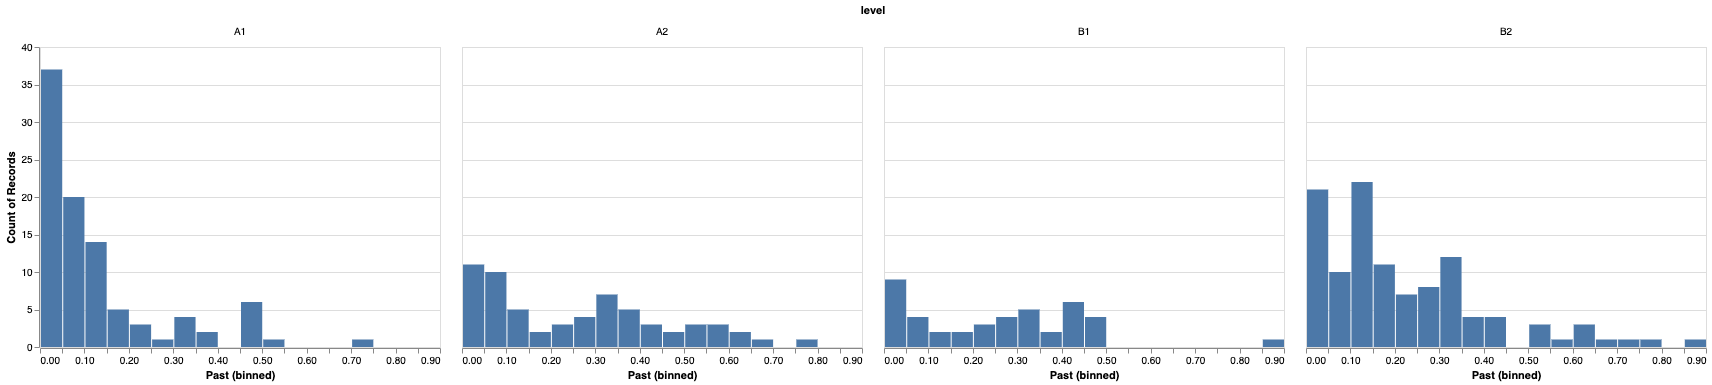

In [36]:
level_verb_tense_df = pd.DataFrame(level_verb_tense)
level_verb_tense_df.head()
alt.Chart(level_verb_tense_df).mark_bar().encode(x = alt.X('Past', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')

### Present Tense

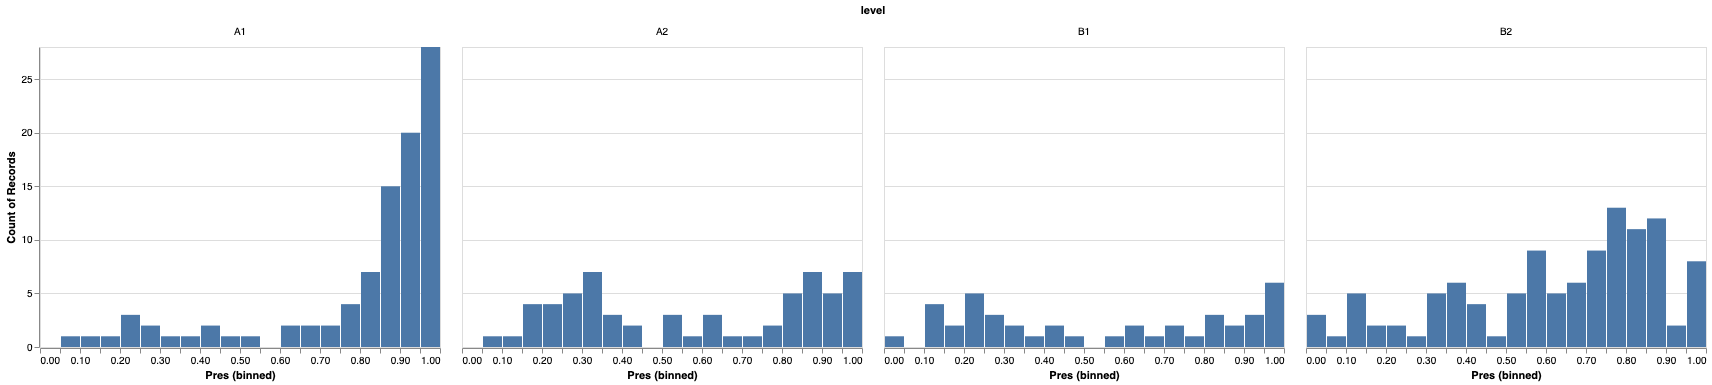

In [37]:
alt.Chart(level_verb_tense_df).mark_bar().encode(x = alt.X('Pres', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')

### Future Tense

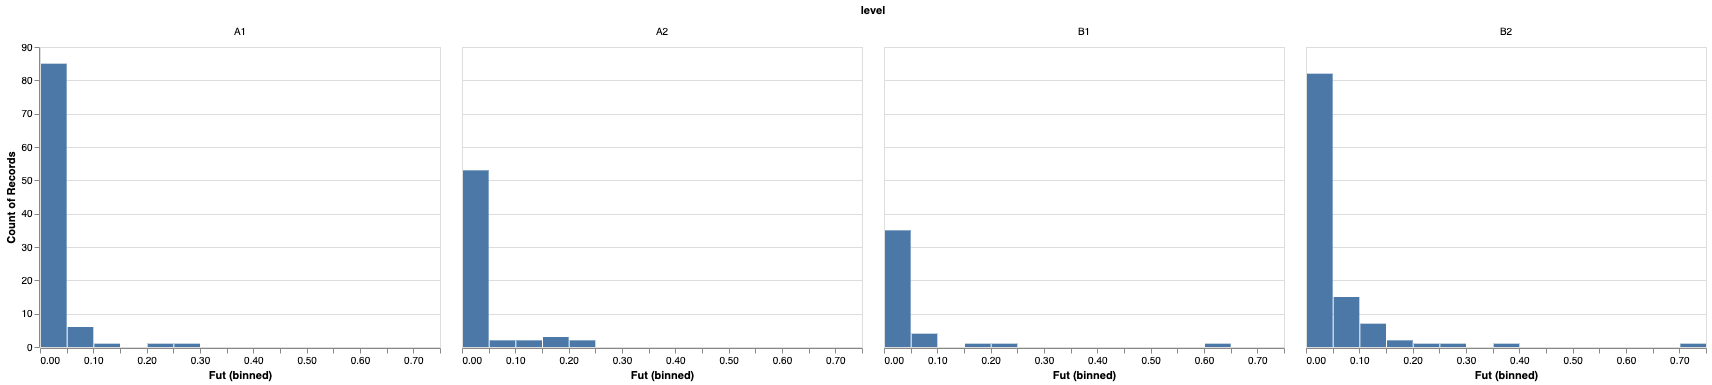

In [38]:
alt.Chart(level_verb_tense_df).mark_bar().encode(x = alt.X('Fut', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')

### Imp Tense

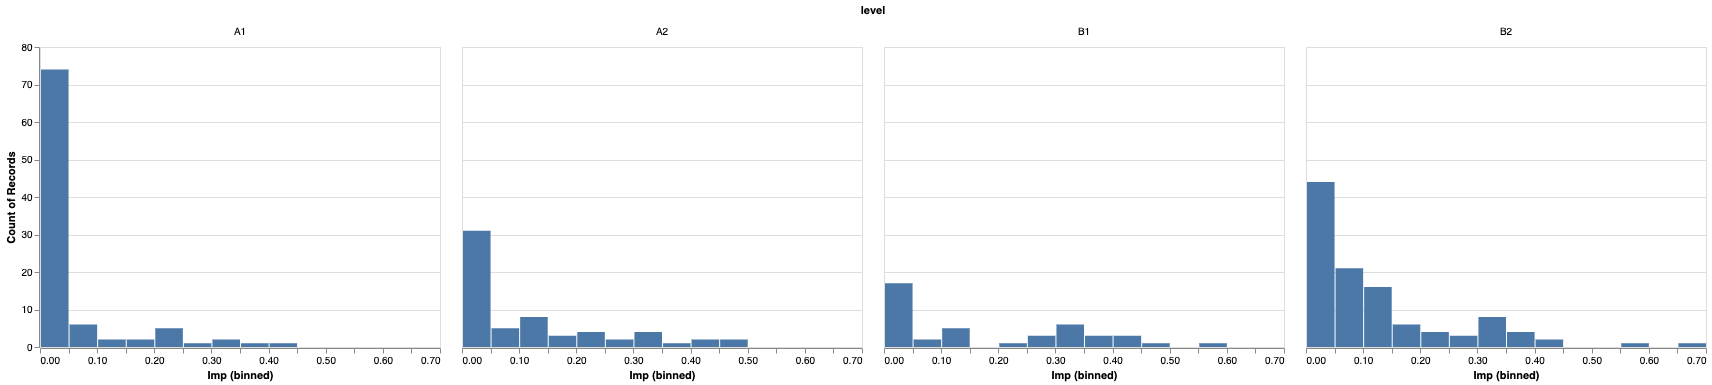

In [39]:
alt.Chart(level_verb_tense_df).mark_bar().encode(x = alt.X('Imp', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')

The codes below are used for debugging. Please ignore them. 

In [40]:
keys = ['Fut', 'Imp', 'Past', 'Pres']
level_verb_tense = defaultdict(list)
corpus_item = corpus['A1']
i = 0
while i < 10:
#for i, text_item in enumerate(corpus_item):
    text_item = corpus_item[i]['content']
    verb_tense_dict = verb_tense(text_item, pipeline)
    print(verb_tense_dict)
    level_verb_tense['level'].append(level)
    for key in keys: 
        if key in verb_tense_dict.keys():
            level_verb_tense[key].append(verb_tense_dict[key])
        else:
            level_verb_tense[key].append(0)
    i += 1

{'Pres': 1.0, 'Fut': 0.0, 'Imp': 0.0, 'Past': 0.0}
{'Pres': 1.0, 'Fut': 0.0, 'Imp': 0.0, 'Past': 0.0}
{'Pres': 1.0, 'Fut': 0.0, 'Imp': 0.0, 'Past': 0.0}
{'Pres': 1.0, 'Fut': 0.0, 'Imp': 0.0, 'Past': 0.0}
{'Pres': 1.0, 'Fut': 0.0, 'Imp': 0.0, 'Past': 0.0}
{'Pres': 0.8703703703703703, 'Past': 0.12962962962962962, 'Fut': 0.0, 'Imp': 0.0}
{'Imp': 0.4268292682926829, 'Pres': 0.2682926829268293, 'Past': 0.2682926829268293, 'Fut': 0.036585365853658534}
{'Imp': 0.3597122302158273, 'Past': 0.49640287769784175, 'Pres': 0.14388489208633093, 'Fut': 0.0}
{'Imp': 0.23880597014925373, 'Past': 0.7014925373134329, 'Pres': 0.05223880597014925, 'Fut': 0.007462686567164179}
{'Imp': 0.16666666666666666, 'Past': 0.3888888888888889, 'Pres': 0.3888888888888889, 'Fut': 0.05555555555555555}
